In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import time
import seaborn as sns
import re
import math
sns.set_style("whitegrid")
sns.set_palette("tab10")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import datetime as dt
plt.style.use('seaborn-notebook')
params = {'legend.fontsize': 15,
          'legend.title_fontsize': 16,
          'figure.figsize': (15, 5),
         'axes.labelsize': 18,
         'axes.titlesize':20,
         'xtick.labelsize':18,
         'ytick.labelsize':18}
plt.rcParams.update(params)
img_fmt = 'svg'

<ipython-input-9-c860b2c07cbb>:18: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
df=pd.read_csv("/content/drive/MyDrive/data pro/netflix_titles.csv")
df.head()
df.info()
df.describe().T

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


,count,mean,std,min,25%,50%,75%,max
release_year,8807.0,2014.180198,8.819312,1925.0,2013.0,2017.0,2019.0,2021.0


In [12]:
df['release_year'] = pd.to_datetime(df['release_year'],format='%Y')
df['date_added'] = pd.to_datetime(df['date_added'])
v_index = df[np.isnan(df['date_added'])].index
df.loc[v_index, 'date_added'] = df.loc[v_index, 'release_year']
df['release_year'] = df['release_year'].dt.year

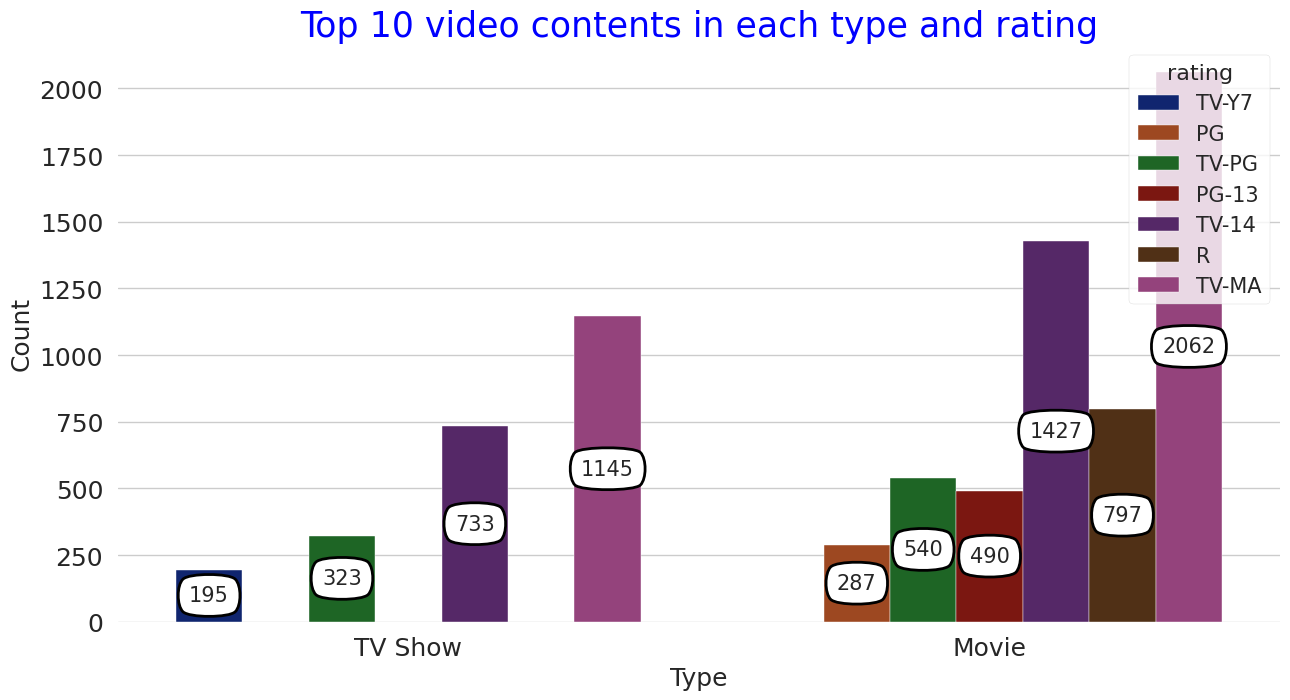

In [13]:
title = 'Top 10 video contents in each type and rating'
df_type_rating = df.groupby(['type','rating']).count().show_id.reset_index().sort_values(by = 'show_id').tail(10)
fig,ax = plt.subplots(figsize = (15,7.5))
plots = sns.barplot(data = df_type_rating, x='type',y = 'show_id', hue = 'rating', palette='dark')
for bar in plots.patches:
    _ = plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height() - (bar.get_height()-3.1)/2), ha='center', va='center',
                   size=15, xytext=(0, 0),bbox=dict(boxstyle="round4,pad=0.6", fc="w", ec="black", lw=2),
                   textcoords='offset points')
_ = plt.box(on=None)
_ = plt.title(title, fontsize = 25, color = 'blue')
_ = plt.xlabel('Type')
_ = plt.ylabel('Count')
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

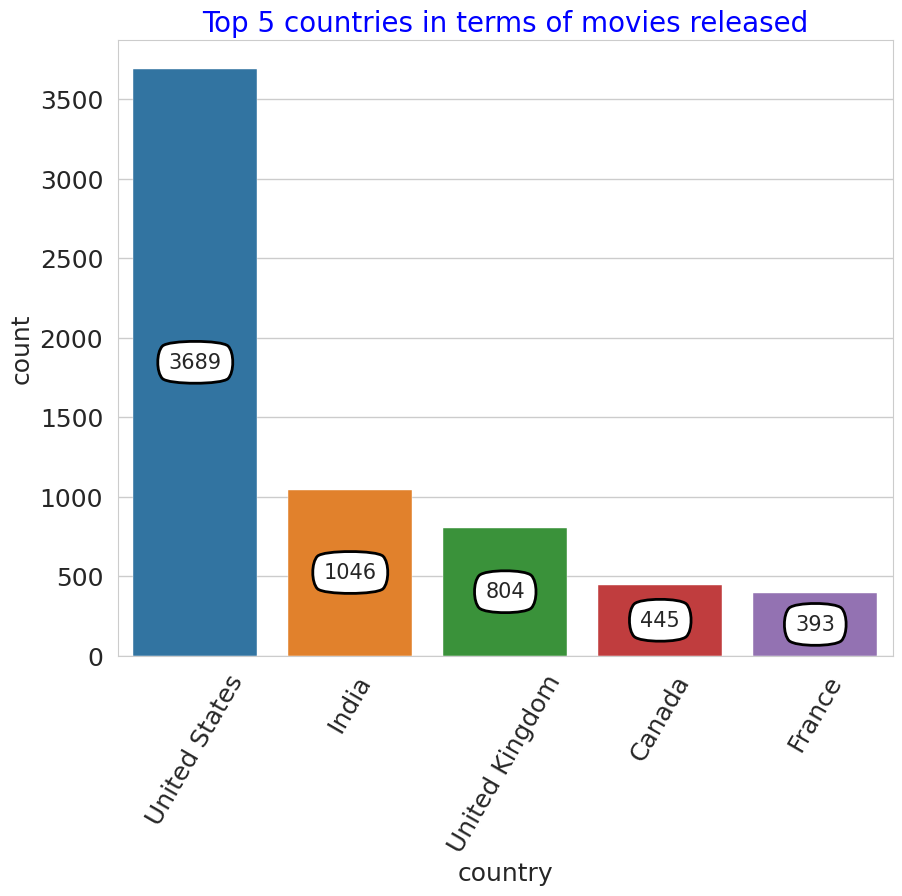

In [14]:
title = 'Top 5 countries in terms of movies released'
countries = {}
for country in df.country.dropna():
    for sub_country in str(country).split(', '):
        if sub_country not in countries:
            countries[sub_country] = 1
        else: countries[sub_country] += 1
df_countries = pd.DataFrame(list(countries.items()),columns = ['country','count']).sort_values(by = ['count'])
_ = plt.subplots(figsize = (10,8))
_ = plt.xticks(rotation = 60)
_ = plt.title(title, color='blue', fontsize=20)
plots = sns.barplot(data = df_countries.tail()[::-1],x= 'country', y='count')
for bar in plots.patches:
    _ = plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height() - (bar.get_height()-3.1)/2), ha='center', va='center',
                   size=15, xytext=(0, 0),bbox=dict(boxstyle="round4,pad=0.6", fc="w", ec="black", lw=2),
                   textcoords='offset points')
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

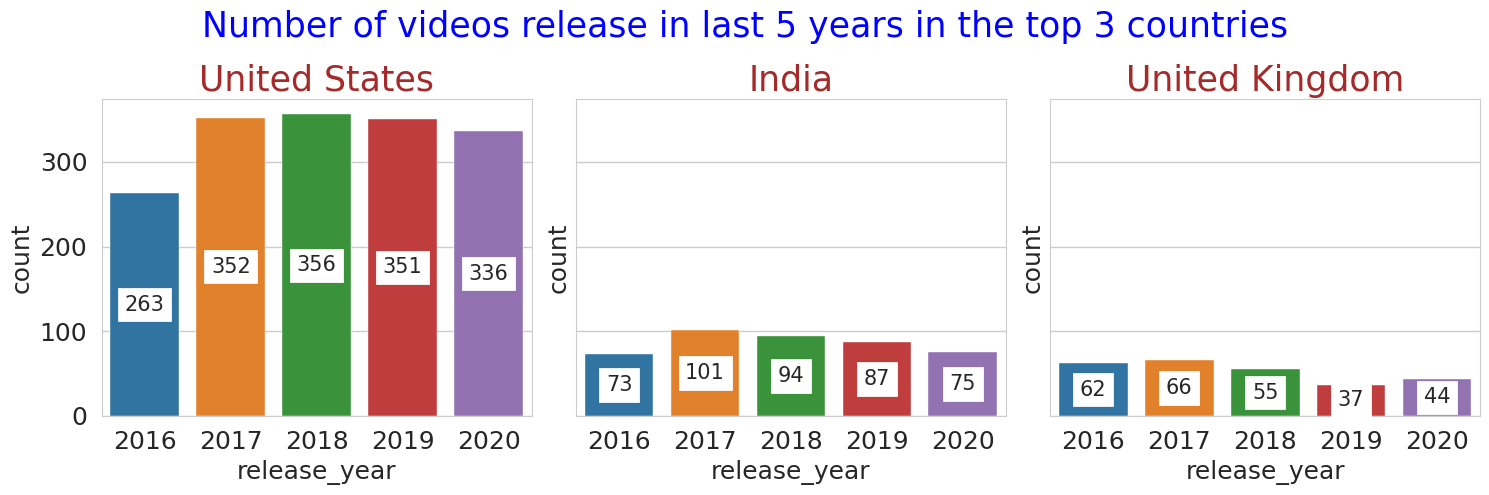

In [15]:
title = 'Number of videos release in last 5 years in the top 3 countries'
fig,ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5),sharey=True)
_ = fig.suptitle(title, fontsize = 25, color = 'blue')
i = 0
for country in df_countries.tail(3).country.values[::-1]:
    df_country = df.loc[df.country == country].loc[(df.release_year>2015) & (df.release_year<=2020)]
    plots = sns.countplot(data = df_country,x= 'release_year', ax = ax[i])
    _ = ax[i].set_title(country,color='brown', fontsize=25)
    for bar in plots.patches:
        _ = plots.annotate(format(bar.get_height(), '.0f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()/2), ha='center', va='center',
                       size=15, xytext=(0, 0),bbox=dict(fc="w", ec="white", lw=2),
                       textcoords='offset points')
    i += 1
fig.tight_layout()
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

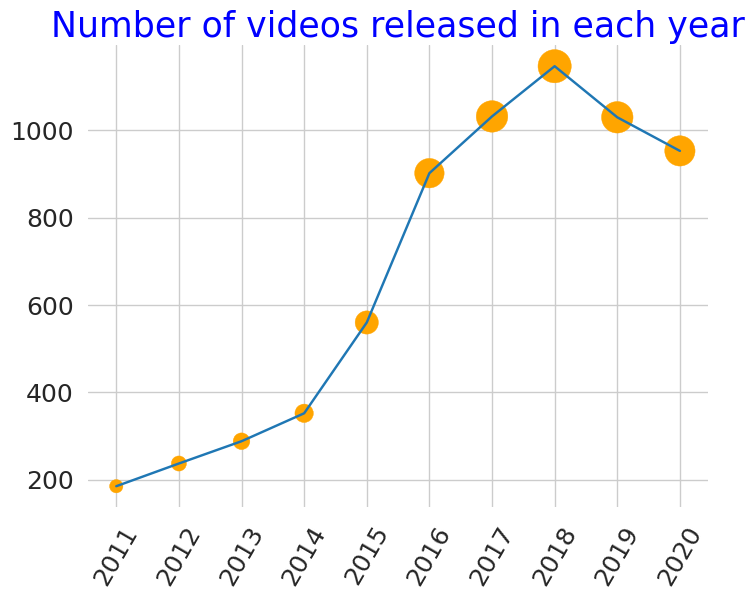

In [16]:
release = df['release_year'].value_counts()
release = release.sort_index(ascending=True)

title = 'Number of videos released in each year'
_ = plt.figure(figsize=(8,6))
_ = plt.plot(release[-11:-1])
_ = plt.scatter(release[-11:-1].index, release[-11:-1].values, s=0.5*release[-11:-1].values, c='orange');
_ = plt.box(on=None);
_ = plt.xticks(rotation = 60)
_ = plt.xticks(release[-11:-1].index);
_ = plt.title(title, color='blue', fontsize=25);
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

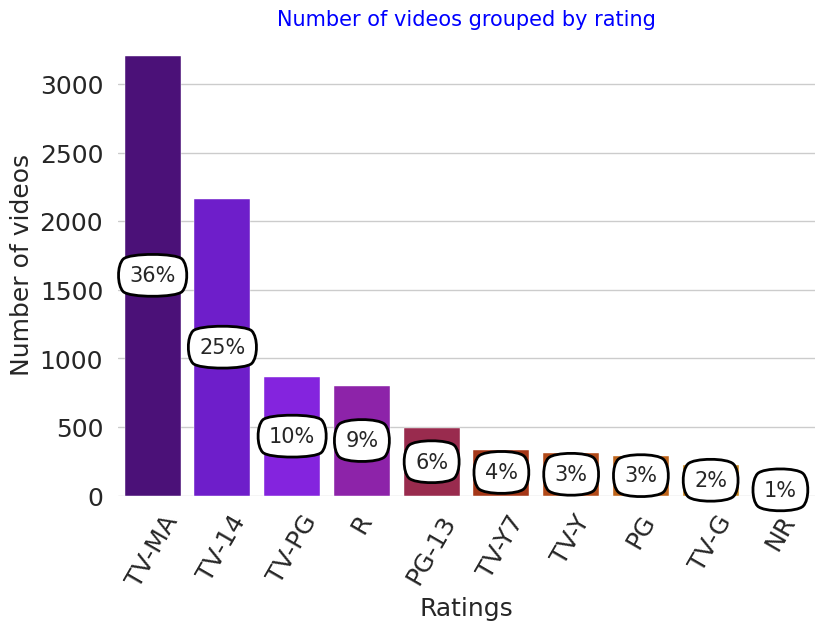

In [17]:
rating = df['rating'].value_counts()


title = 'Number of videos grouped by rating'
_ = plt.figure(figsize=(9,6));
_ = plt.title(title, color='blue', fontsize=15)
plots = sns.barplot(y=rating.values[:10], x=rating.index[:10], palette='gnuplot',orient='v');
for bar in plots.patches:
    _ = plots.annotate(format(bar.get_height()/rating.sum()*100, '.0f')+'%',
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height() - (bar.get_height()-3.1)/2), ha='center', va='center',
                   size=15, xytext=(0, 0),bbox=dict(boxstyle="round4,pad=0.6", fc="w", ec="black", lw=2),
                   textcoords='offset points')
_ = plt.box(on=None)
_ = plt.xlabel('Ratings')
_ = plt.xticks(rotation = 60)
_ = plt.ylabel('Number of videos')
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

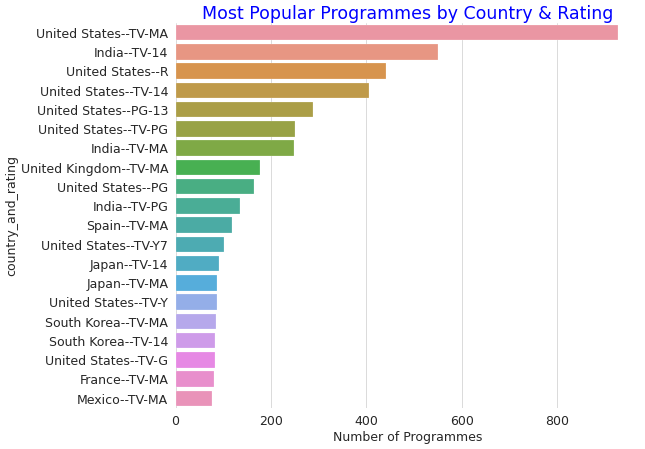

In [18]:
country_rating = df.groupby(['country', 'rating']).count().sort_values('show_id', ascending=False).reset_index()
country_rating['country_and_rating'] = country_rating[['country','rating']].apply(axis=1,func = lambda x : str(x.country)+'--'+str(x.rating))
country_rating.set_index(keys = 'country_and_rating', inplace = True)

title = 'Most Popular Programmes by Country & Rating'
_ = plt.figure(figsize=(12,10), dpi = 50)
plots = sns.barplot(y=country_rating.index[:20], x = country_rating['show_id'][:20]);
_ = plt.box(on=None)
_ = plt.title(title, fontsize=25, color='blue')
_ = plt.xlabel('Number of Programmes');
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

<ipython-input-19-939bb9a98d24>:9: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



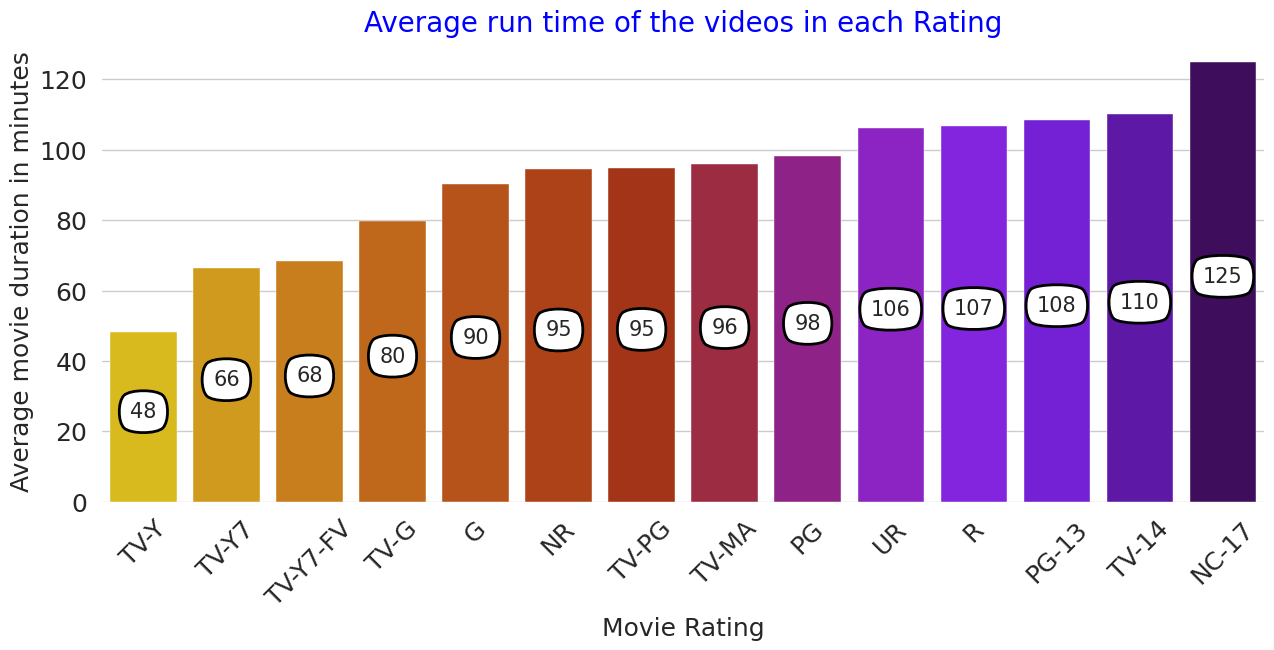

In [19]:
movie = df.copy()
movie = movie[movie['type'] == 'Movie']

movie['minute'] = movie.duration.apply(lambda x: 0 if str(x) == 'nan' else int(str(x).replace(' min','')))

movie.rating = movie.rating.apply(lambda x: pd.NA if str(x).endswith('min') else x)

duration_rating = movie.groupby(['rating']).mean().sort_values('minute')
title = 'Average run time of the videos in each Rating'
_ = plt.figure(figsize=(15,6))
plots = sns.barplot(x=duration_rating.index, y=duration_rating.minute.values, palette='gnuplot_r')
for bar in plots.patches:
    _ = plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height() - (bar.get_height()-3.1)/2), ha='center', va='center',
                   size=15, xytext=(0, 0),bbox=dict(boxstyle="round4,pad=0.6", fc="w", ec="black", lw=2),
                   textcoords='offset points')
_ = plt.box(on=None)
_ = plt.title(title, fontsize = 20, color = 'blue')
_ = plt.xlabel('Movie Rating')
_ = plt.xticks(rotation = 45)
_ = plt.ylabel('Average movie duration in minutes')
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

<ipython-input-20-85527cc35b8c>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



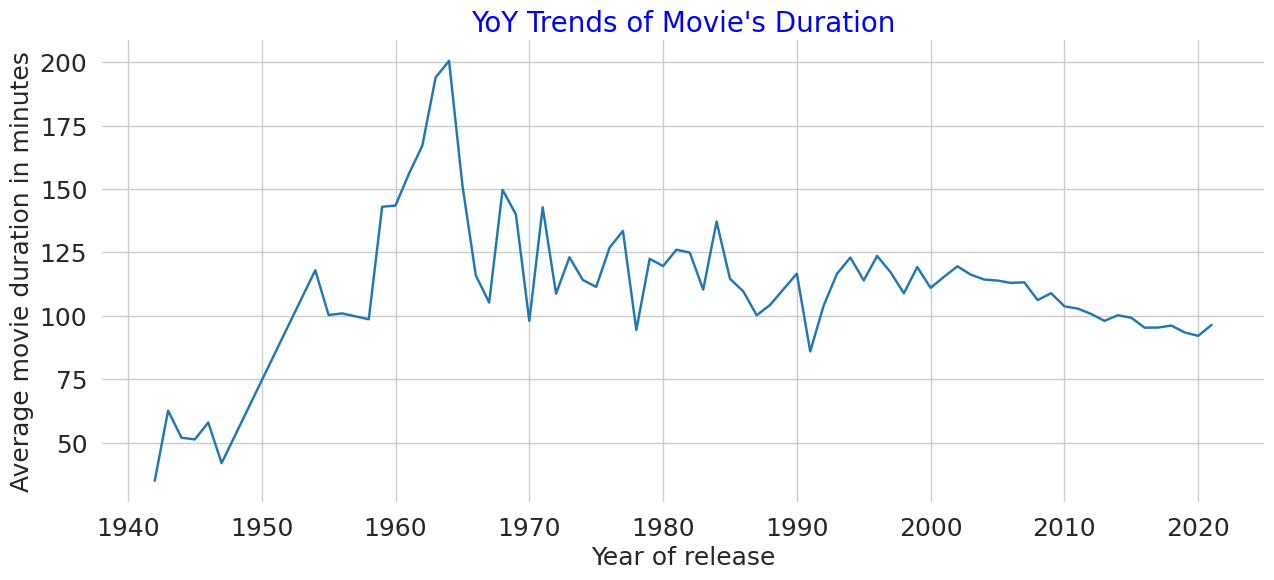

In [20]:
duration_year = movie.groupby(['release_year']).mean().sort_values('minute')
duration_year = duration_year.sort_index()

title = "YoY Trends of Movie's Duration"
_ = plt.figure(figsize=(15,6))
_ = sns.lineplot(x=duration_year.index, y=duration_year.minute.values)
_ = plt.box(on=None)
_ = plt.ylabel('Average movie duration in minutes');
_ = plt.xlabel('Year of release');
_ = plt.title(title, fontsize=20, color='blue');
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

<ipython-input-21-41ca89697dce>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Text(0.5, 0, 'Length of Total Movies Released in Minutes')

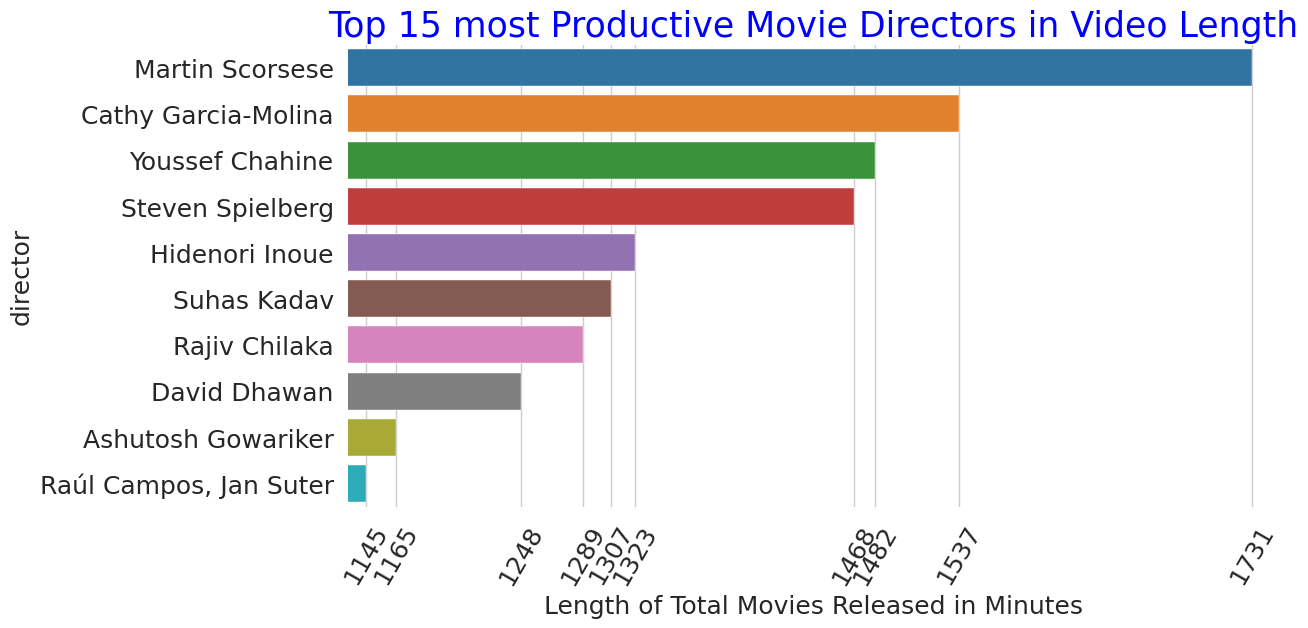

In [21]:
director_minute = movie.groupby('director').sum().sort_values('minute', ascending=False)
title = 'Top 15 most Productive Movie Directors in Video Length'
_ = plt.figure(figsize=(12,6))
_ = sns.barplot(y=director_minute.index[:10], x=director_minute.minute[:10]);
_ = plt.title(title, color='blue', fontsize=25)
_ = plt.xticks(director_minute.minute[:10],rotation = 60)
_ = plt.xlim(min(director_minute.minute[:10])/10*9.9,max(director_minute.minute[:10])/10*10.1)
_ = plt.box(on=None)
plt.xlabel('Length of Total Movies Released in Minutes');
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

Text(0.5, 0, 'Count of Total Movies Released')

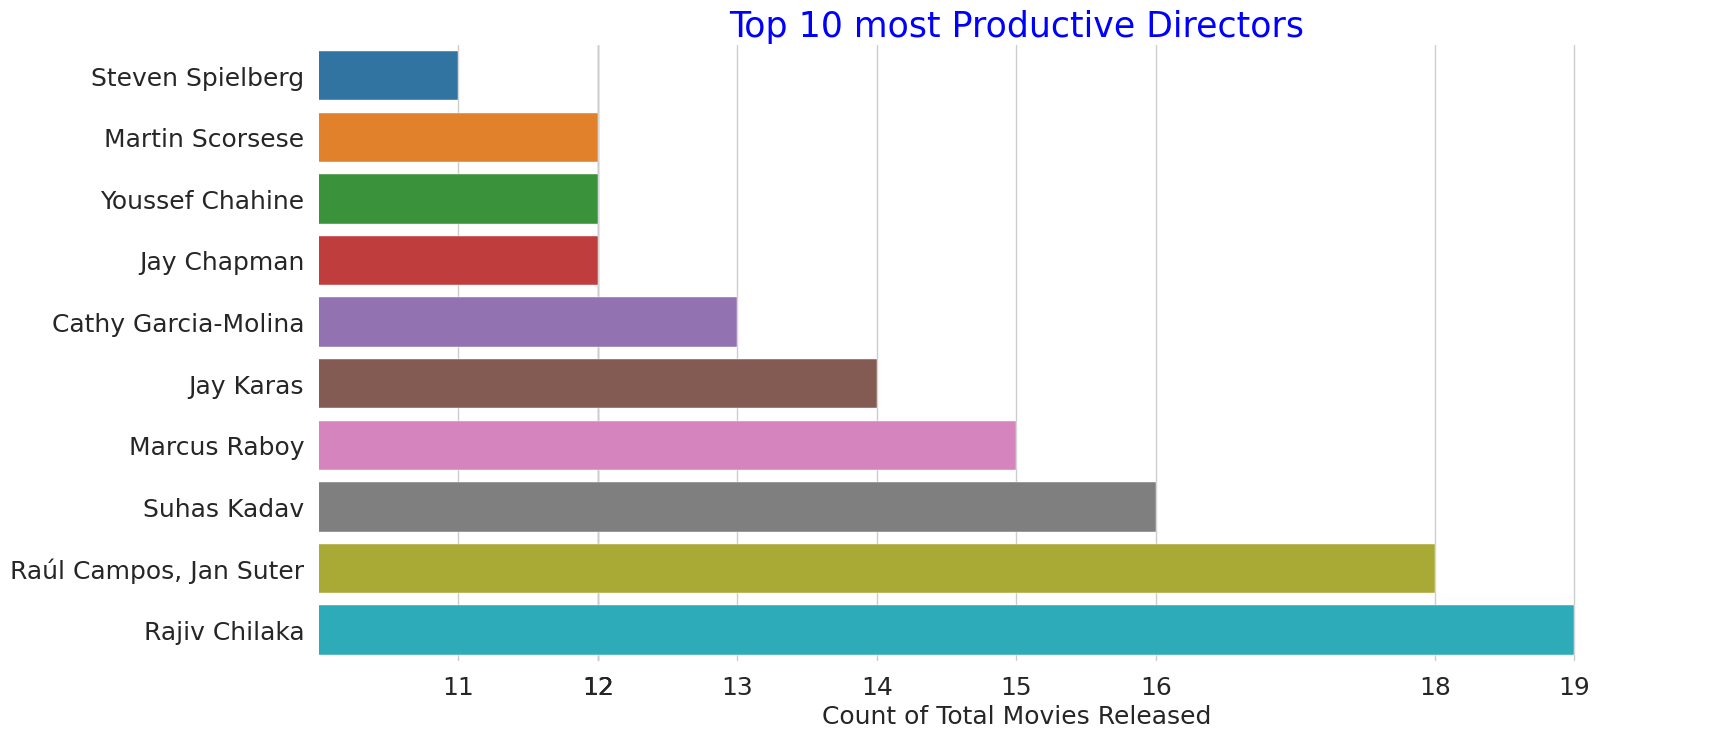

In [22]:
title = 'Top 10 most Productive Directors'
_ = plt.figure(figsize=(18,8))
_ = sns.barplot(y=movie.director.value_counts()[:10].sort_values().index, x=movie.director.value_counts()[:10].sort_values().values);
_ = plt.title(title, color='blue', fontsize=25)
_ = plt.box(on=None)
_ = plt.xticks(movie.director.value_counts()[:10].sort_values().values);
_ = plt.xlim(min(movie.director.value_counts()[:10])-1,max(movie.director.value_counts()[:10])+1)
plt.xlabel('Count of Total Movies Released');
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

<ipython-input-23-6b42bc593a14>:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-23-6b42bc593a14>:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-23-6b42bc593a14>:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-23-6b42bc593a14>:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-23-6b42bc593a14>:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-23-6b42bc593a14>:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

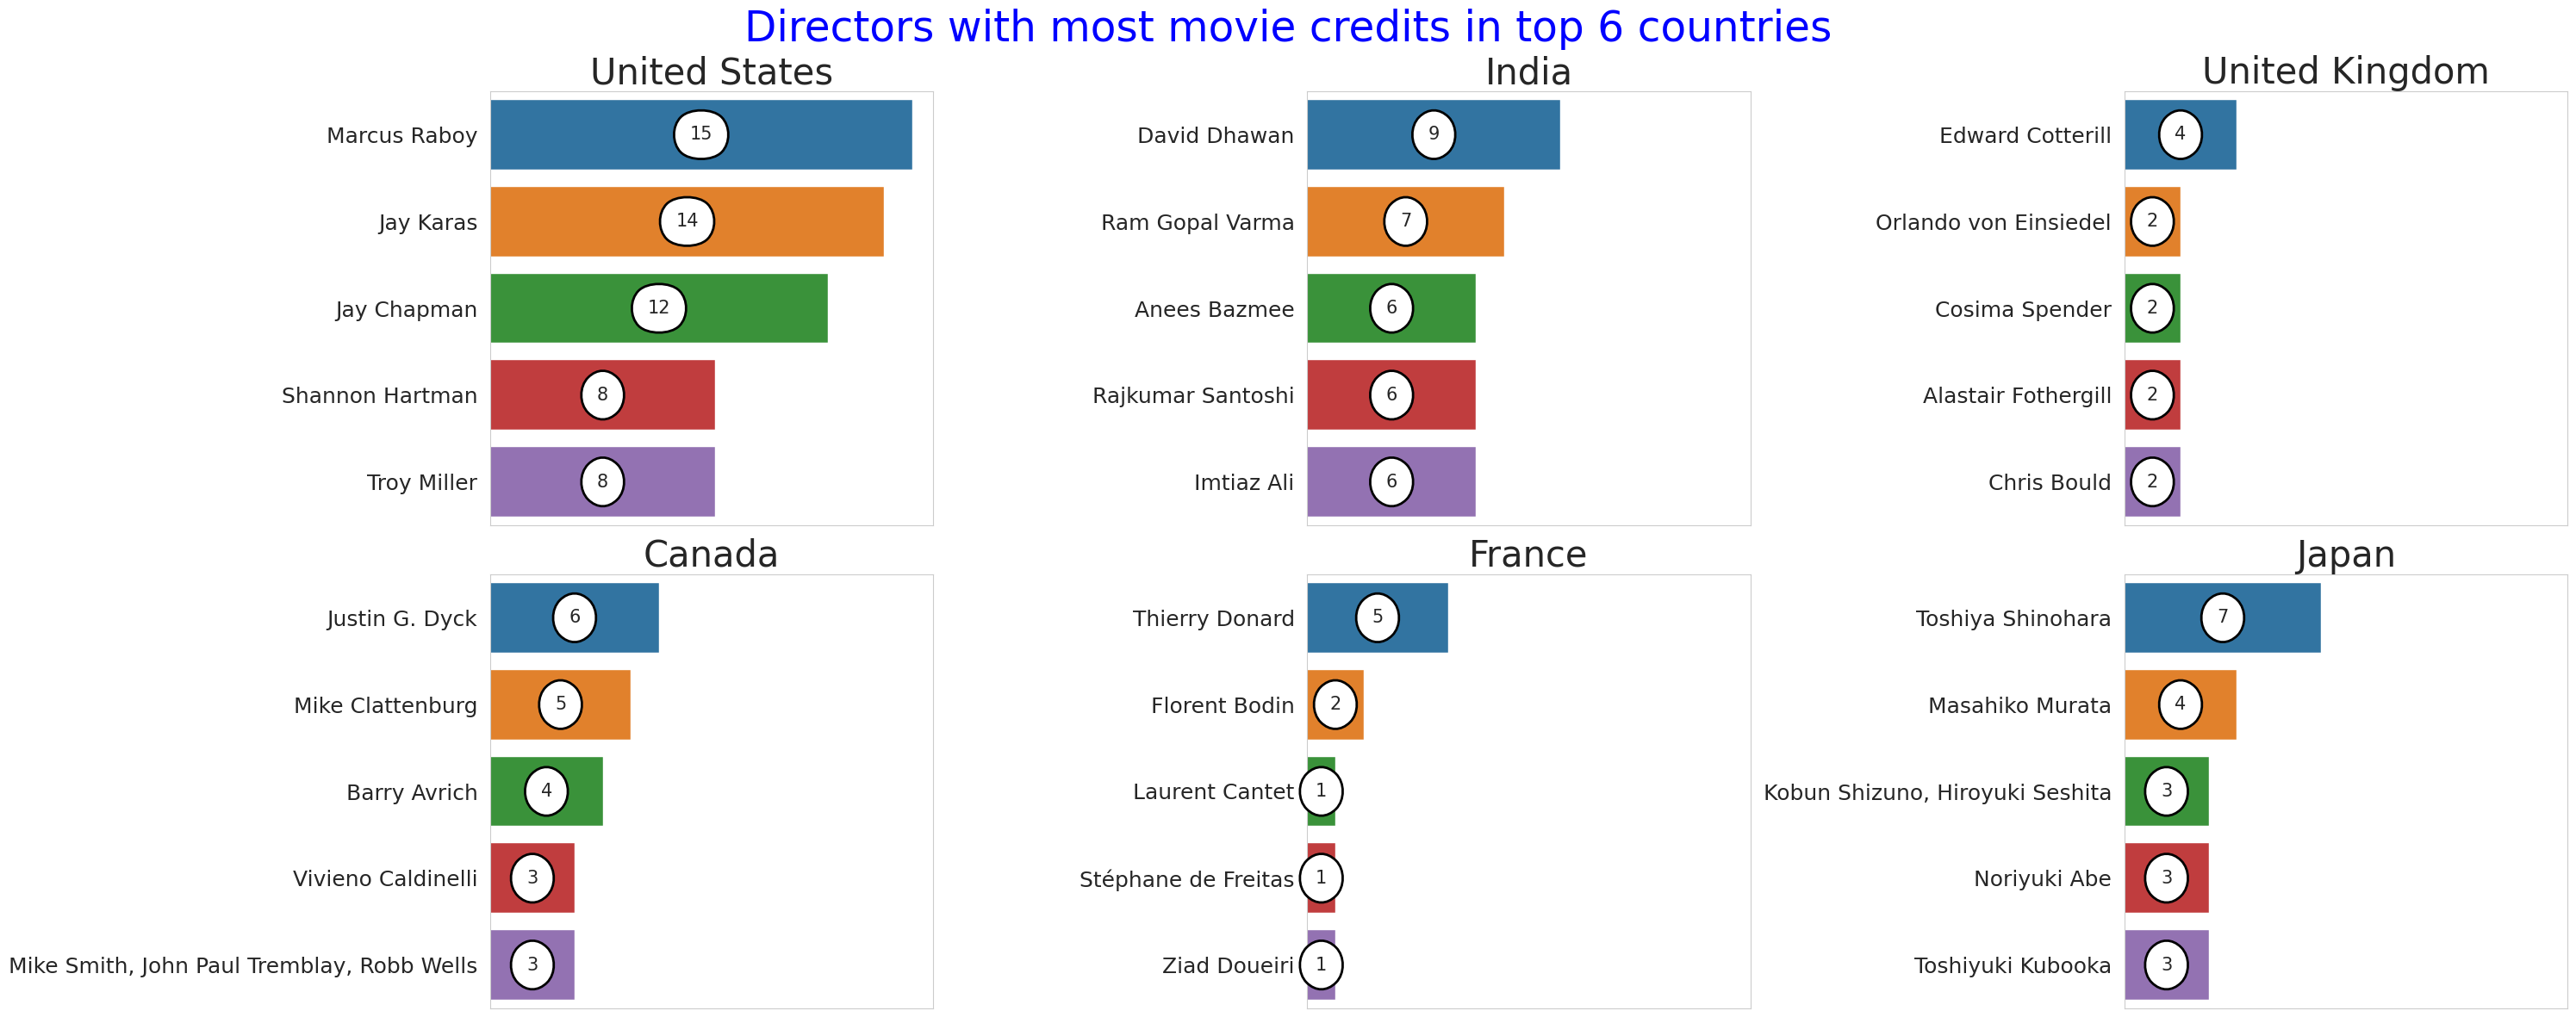

In [23]:
title = 'Directors with most movie credits in top 6 countries'
df_country = pd.DataFrame()
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (30,12), sharex = True)
_ = fig.suptitle(title, fontsize = 35, color = 'blue')
i,j = 0,0
n_countries = 6
n_directors = 5
for country in df_countries.tail(n_countries).country.values[::-1]:
    t_df = df[df.country == country].groupby(['director','country'], sort = False).count().sort_values('release_year')[-n_directors:][::-1].reset_index()
    plots = sns.barplot(data=t_df,y = 'director', x = 'release_year', ax =ax[i,j])
    for bar in plots.patches:
        _ = plots.annotate(format(bar.get_width(), '.0f'),
               (bar.get_width()/2,
                bar.get_y() + bar.get_height() / 2), ha='center', va='center',
               size=15, xytext=(0, 0),bbox=dict(boxstyle="round4,pad=1", fc="w", ec="black", lw=2),
               textcoords='offset points')
    _ = ax[i,j].set_xticks([])
    _ = ax[i,j].set_title(country,fontsize=30)
    _ = ax[i,j].set_xlabel('')
    _ = ax[i,j].set_ylabel('')
    df_country = df_country.append(t_df)
    j += 1
    if j> n_countries/2-1:
        j = 0
        i = 1
fig.tight_layout()
plt.savefig(title+'.'+img_fmt, format = img_fmt)

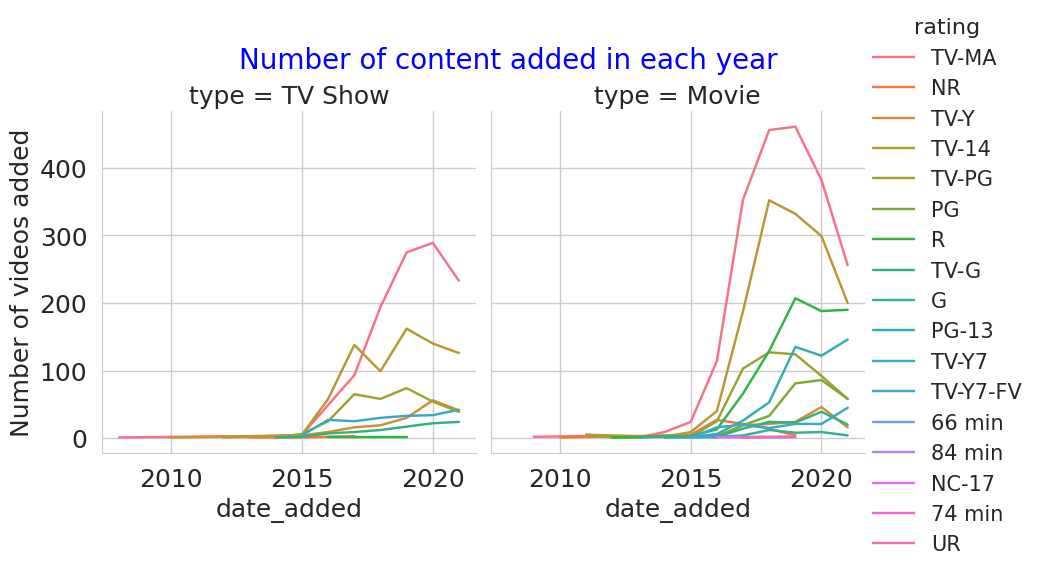

In [24]:
df_data_added = df[df.date_added >'2008-01-01'].groupby([df.date_added.dt.year,df.type,df.rating]).count().show_id.reset_index()
title = 'Number of content added in each year'
g = sns.relplot(data = df_data_added, x = 'date_added', y = 'show_id', col = 'type', hue ='rating',kind = 'line', markers = True,aspect = 0.9, height = 5)
_ = g.axes[0,0].set_ylabel('Number of videos added')
_ = g.fig.suptitle(title, color = 'blue',fontsize = 20)
_ = g.fig.subplots_adjust(top=0.85)
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

In [25]:
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip().replace(" ","_") for i in l.split(",")])
df['genres'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip().replace(" ","_") for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip().replace(" ","_") for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip().replace(" ","_") for i in l.split(",")])
df['all_features'] = df['directors'] + df['genres'] + df['actors'] + df['countries']
df['all_features'] = df['all_features'].apply(lambda x: " ".join(x))

In [26]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [27]:
def text_cleanser(text):
    stemmer = WordNetLemmatizer()
    text = ''.join([char for char in text if (char.isalpha() or char.isspace()) and char !="'"])
    text = [word.lower() for word in text.split() if word.lower() not in stopwords.words('english')]
    return [stemmer.lemmatize(word) for word in text]
sample_text = "Hello! This is me. I need to verify whether this sentence is working correctly."
print(text_cleanser(sample_text))

['hello', 'need', 'verify', 'whether', 'sentence', 'working', 'correctly']


In [28]:
df_desc = df[['show_id','description']].set_index('show_id')
df_desc['trunc_desc'] = df_desc['description'].apply(lambda x : text_cleanser(x))

In [29]:
vocabulary = {}
for words in df_desc.trunc_desc:
    for word in words:
        if word in vocabulary:
            vocabulary[word] = vocabulary[word] + 1
        else:
            vocabulary[word] = 1
df_voc = pd.DataFrame(list(vocabulary.items()),columns = ['text','count'])

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
bow_transformer = CountVectorizer(analyzer = text_cleanser).fit(df_desc['description'])
desc_bow = bow_transformer.transform(df_desc['description'])
print('Shape of the generated matrix : ',desc_bow.shape)
sparsity = desc_bow.nnz/(desc_bow.shape[0]*desc_bow.shape[1])*100.0
print('Sparsity of the generated matrix',round(sparsity,4))

Shape of the generated matrix :  (8807, 18085)
Sparsity of the generated matrix 0.079


In [31]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,directors,genres,actors,countries,all_features
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",[Kirsten_Johnson],[Documentaries],[],[United_States],Kirsten_Johnson Documentaries United_States
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",[],"[International_TV_Shows, TV_Dramas, TV_Mysteries]","[Ama_Qamata, Khosi_Ngema, Gail_Mabalane, Thaba...",[South_Africa],International_TV_Shows TV_Dramas TV_Mysteries ...
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,[Julien_Leclercq],"[Crime_TV_Shows, International_TV_Shows, TV_Ac...","[Sami_Bouajila, Tracy_Gotoas, Samuel_Jouy, Nab...",[],Julien_Leclercq Crime_TV_Shows International_T...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",[],"[Docuseries, Reality_TV]",[],[],Docuseries Reality_TV
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,[],"[International_TV_Shows, Romantic_TV_Shows, TV...","[Mayur_More, Jitendra_Kumar, Ranjan_Raj, Alam_...",[India],International_TV_Shows Romantic_TV_Shows TV_Co...


In [32]:
vector = TfidfVectorizer(max_df=1.0, min_df=1,strip_accents = 'ascii', stop_words='english',lowercase=True,use_idf=True,norm=u'l2',smooth_idf=True)
tfidf = vector.fit_transform(df.all_features)

In [33]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import linear_kernel
k = 400
kmeans = MiniBatchKMeans(n_clusters = k, init = 'k-means++')
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names_out()
request_transform = vector.transform(df['all_features'])
df['cluster'] = kmeans.predict(request_transform)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



MiniBatchKMeans(n_clusters=400)

In [34]:
def find_similar_movies(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]

In [35]:
for ind in find_similar_movies(tfidf,0,5):
    print(df.loc[ind].title)

The Minimalists: Less Is Now
Crip Camp: A Disability Revolution
Murder to Mercy: The Cyntoia Brown Story
Free to Play
Virunga: Gorillas in Peril


In [36]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])
    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['genres']:
        G.add_node(element,label="GENRE")
        G.add_edge(rowi['title'], element, label="GENRE_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")

    indices = find_similar_movies(tfidf, i, top_n = 3)
    snode="Sim("+rowi['title'][:15].strip()+")"
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))

 finish -- 71.06167364120483 seconds --


In [37]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph, title = ""):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    sizes = []
    std_size = 500
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('#b3042c')
            sizes.append(std_size*5)
        elif G.nodes[e]['label']=="PERSON":
            colors.append('#047d59')
            sizes.append(std_size*2.5)
        elif G.nodes[e]['label']=="GENRE":
            colors.append('#3a018a')
            sizes.append(std_size)
        elif G.nodes[e]['label']=="COU":
            colors.append('#bd3102')
            sizes.append(std_size*0.9)
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('#b87906')
            sizes.append(std_size)
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('#cdf7e9')
            sizes.append(std_size*0.9)
    fig, ax = plt.subplots(figsize = (18,18))
    nx.draw(subgraph, with_labels=True, alpha = 0.8, node_shape = 'o' ,node_size = sizes,cmap = 'Accent', edge_color = 'white',font_color = 'white',font_weight='bold',node_color=colors)
    ax.set_title('Recommendations after watching The video '+title+' :-', color='white', size = 30)
    ax.axis('off')
    fig.set_facecolor('#44495c')
    plt.tight_layout()
    plt.show()

In [38]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key)
        weight.append(w)

    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)
    return result

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



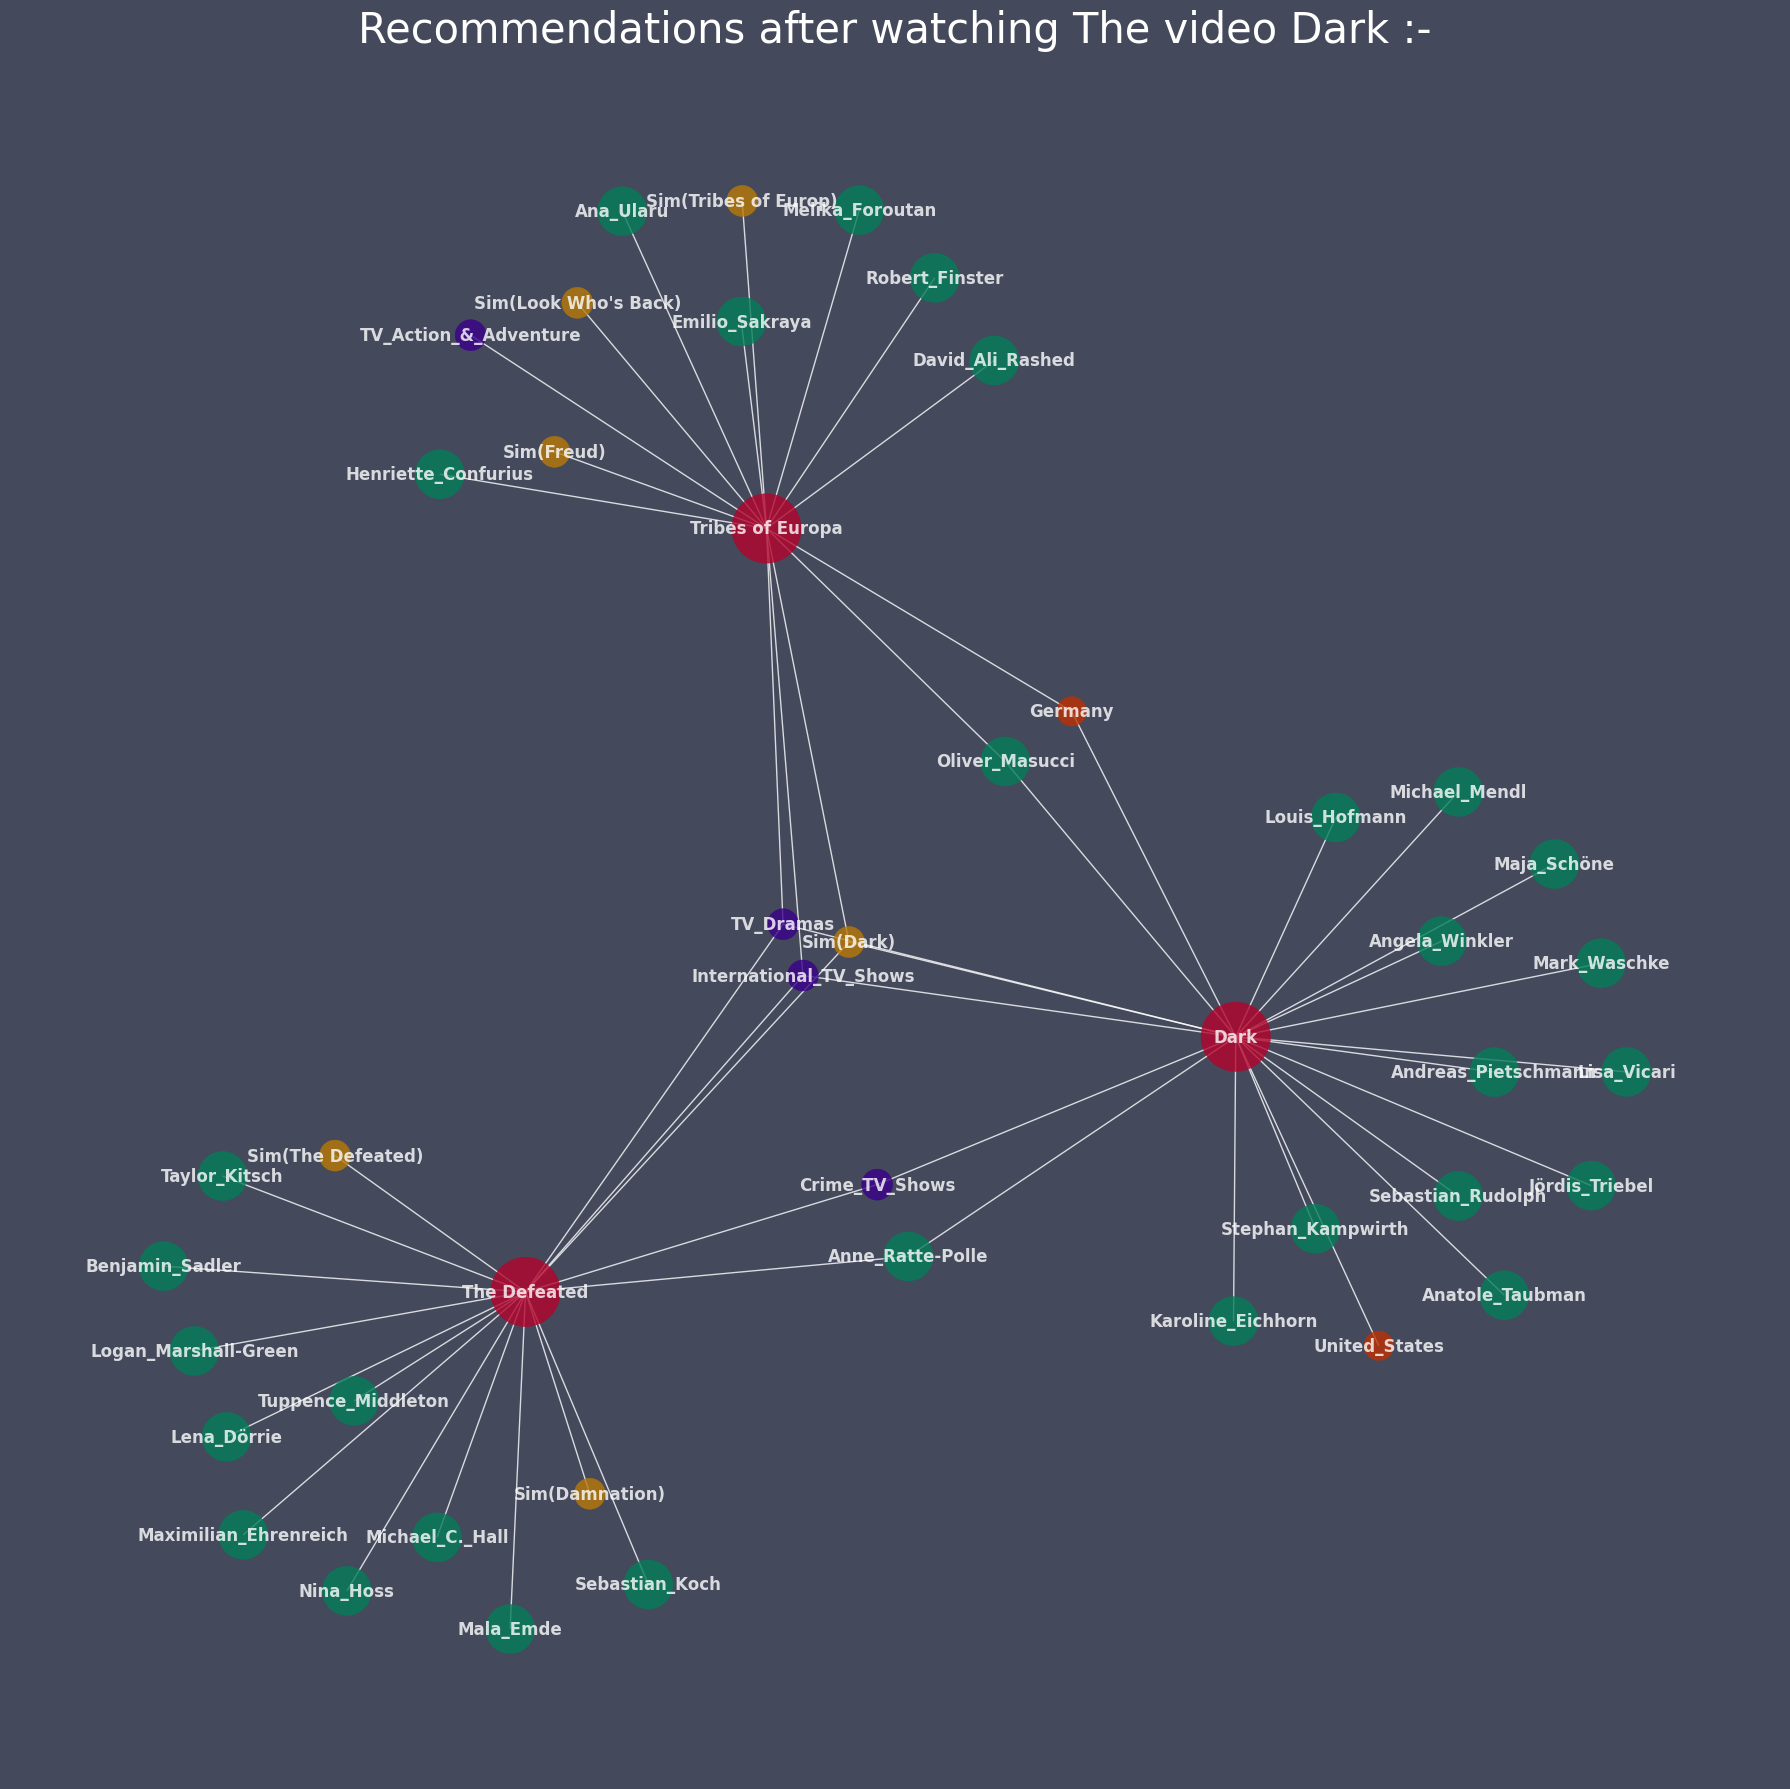

In [39]:
Movie="Dark"
recommendation = get_recommendation(Movie)
rel_graph = get_all_adj_nodes([Movie]+list(recommendation.index[:2]))
draw_sub_graph(rel_graph,Movie)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



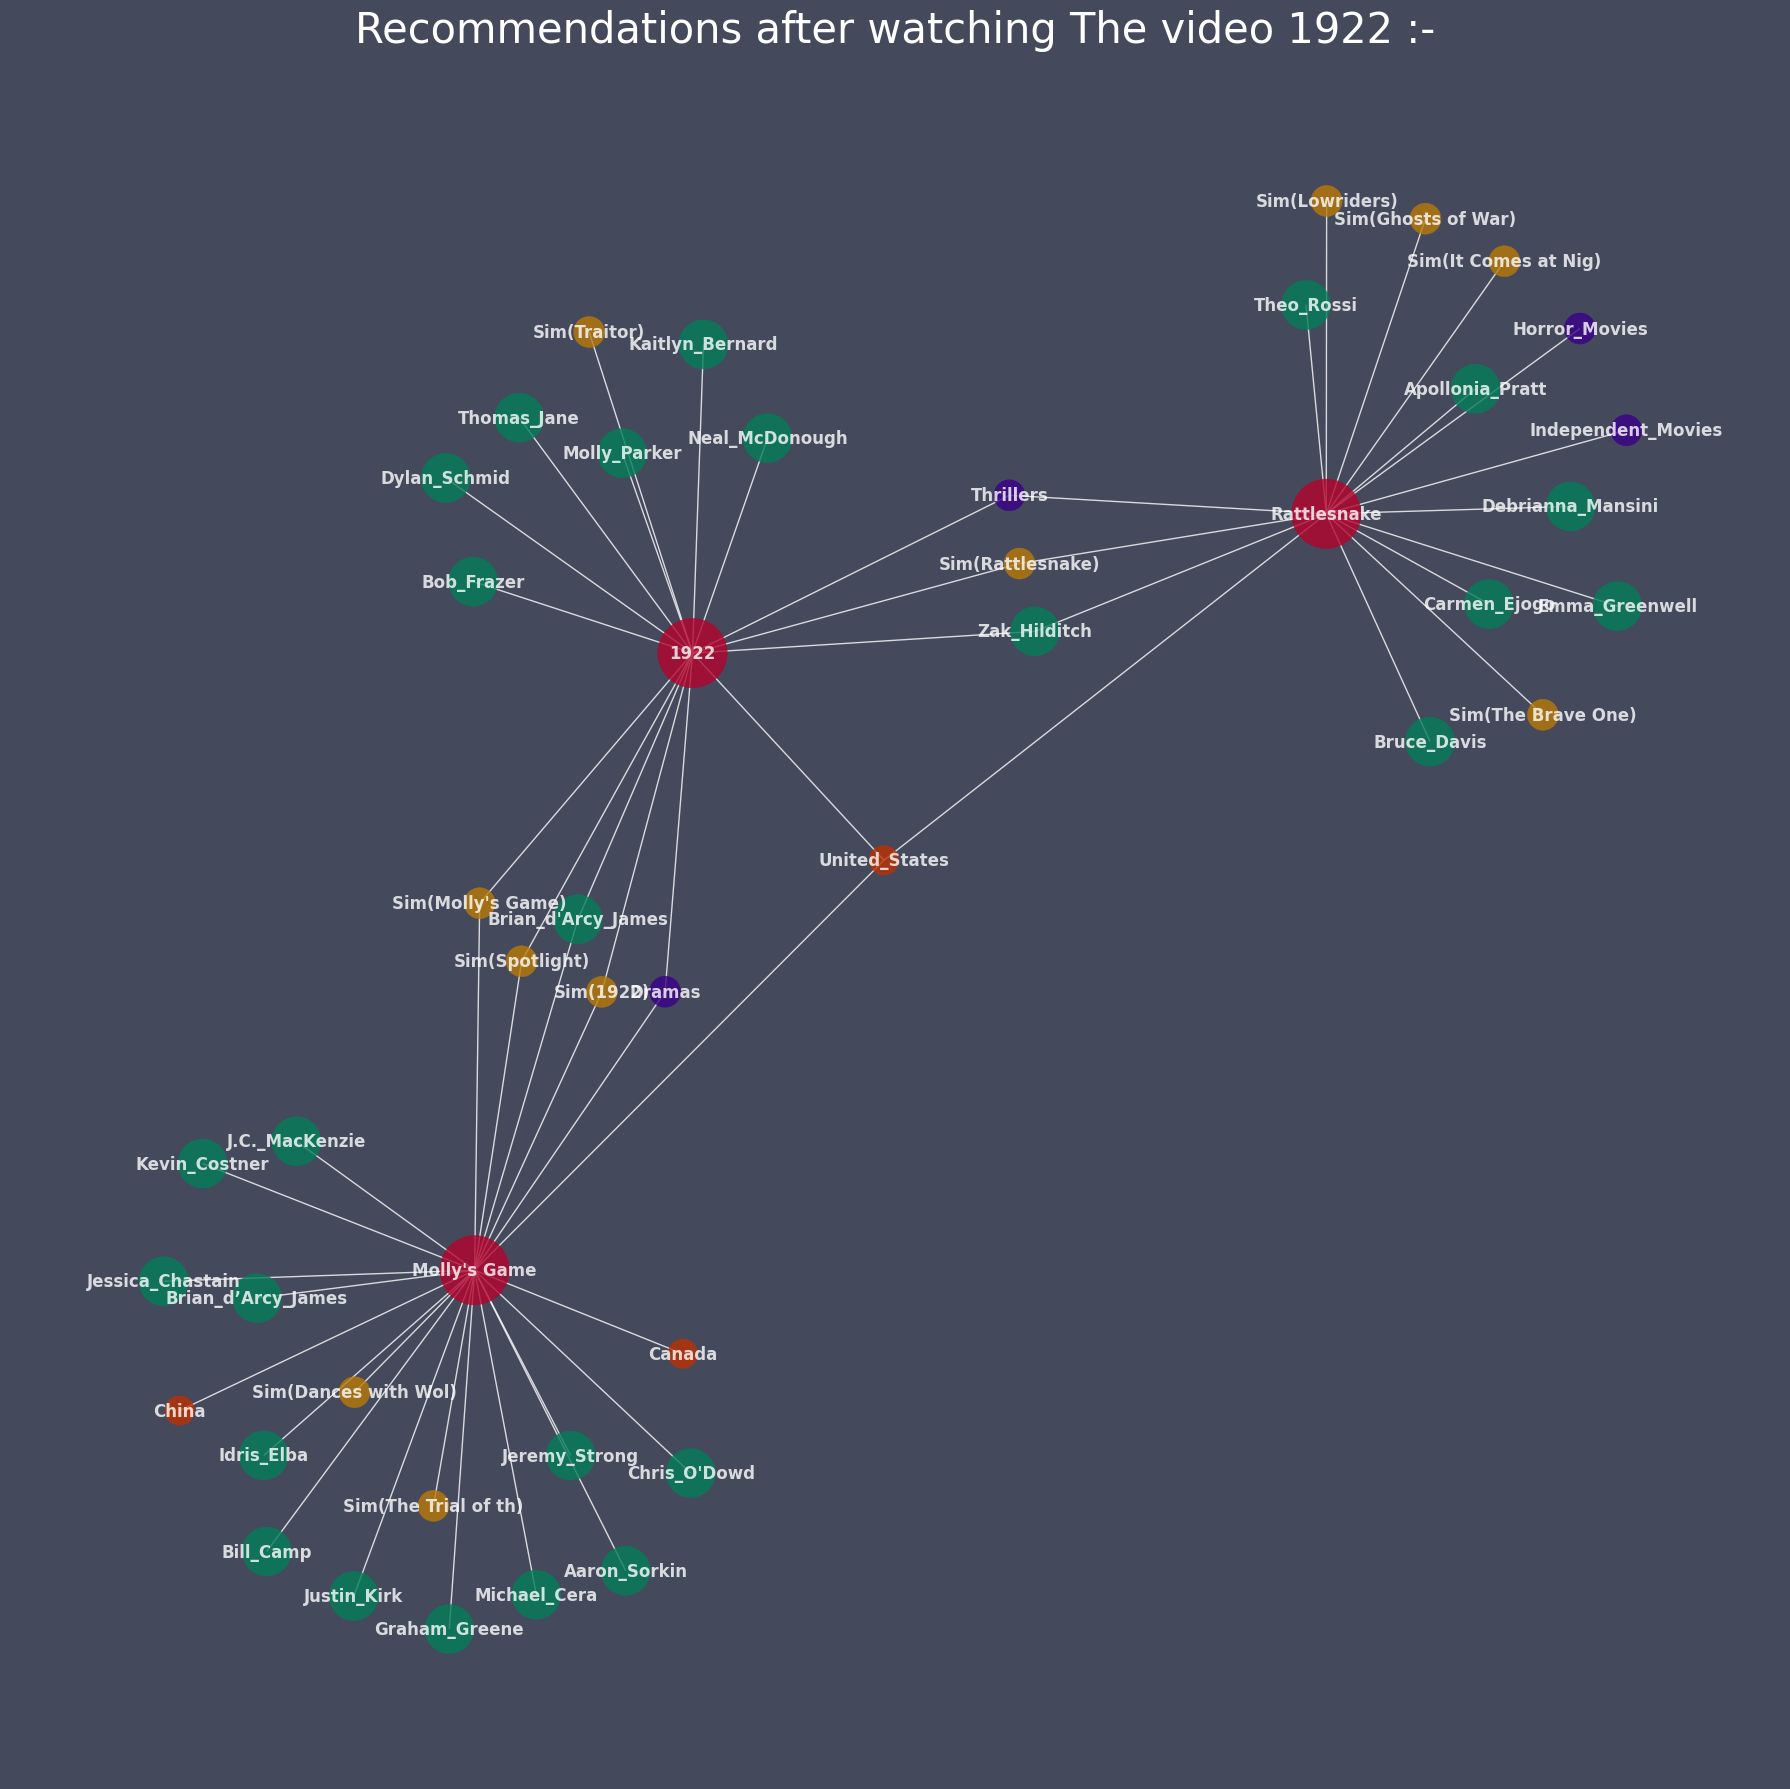

In [40]:
Movie="1922"
recommendation = get_recommendation(Movie)
rel_graph = get_all_adj_nodes([Movie]+list(recommendation.index[:2]))
draw_sub_graph(rel_graph,Movie)